In [2]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

import torch.cuda

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as func

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

![](https://cs6.pikabu.ru/avatars/678/v678879-2024588938.jpg) Начнем нашу работу с проверки GPU

In [2]:
train_on_gpu = torch.cuda.is_available()
DEVICE = torch.device("cpu")

if not train_on_gpu:
    print('CUDA не доступна. Обучение проходит на CPU')
else:
    DEVICE = torch.device("cuda")
    print('CUDA доступна. Обучение проходит на GPU')

CUDA доступна. Обучение проходит на GPU


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
RESCALE_SIZE = 224

In [5]:
#!kaggle competitions download -c journey-springfield
#!cp -r "../input/journey-springfield" "./"

# Разделение датасета

Создадим переменные, содержащие пути до папок train/test

In [6]:
test_path = Path('../input/journey-springfield/testset/testset')
train_path = Path('../input/journey-springfield/train/simpsons_dataset')

Отсортируем файлы и дадим класс (имя) каждому изображению из теста

In [7]:
train_val_files = sorted(list(train_path.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

In [8]:
test_val_files = sorted(list(test_path.rglob('*.jpg')))
test_val_labels = [i.parent.name for i in test_val_files]

# Анализ данных

Рассмотрим на распределение классов

In [9]:
df = pd.DataFrame(train_val_labels, columns=['name'])
df['count'] = 1
df = df.groupby('name').count().sort_values('count')

Проверим как выглядит таблица. Выведем случайные строки

In [10]:
df.sample(n=7)

,count
name,
barney_gumble,106
professor_john_frink,65
comic_book_guy,469
bart_simpson,1342
patty_bouvier,72
moe_szyslak,1452
sideshow_mel,40


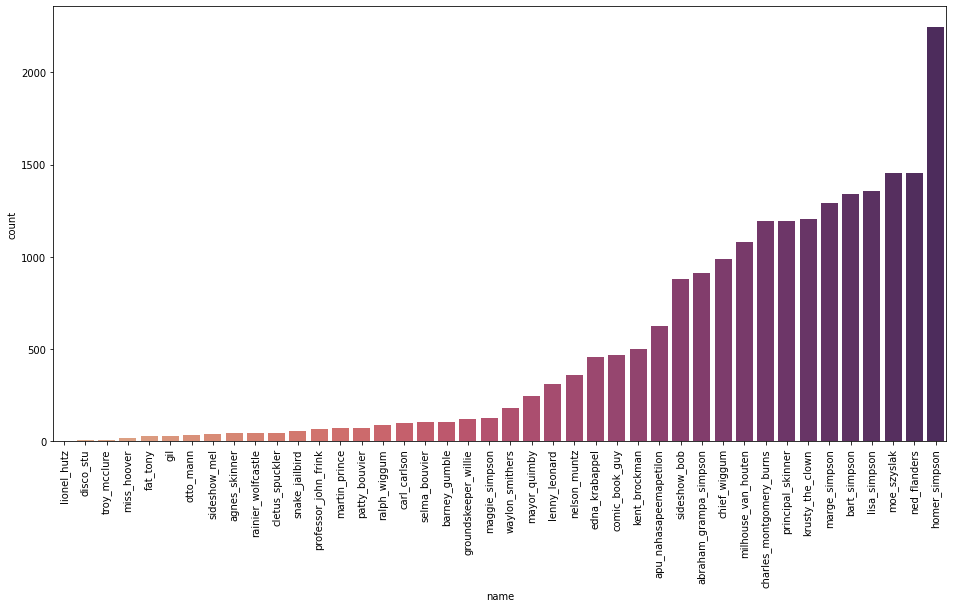

In [11]:
plt.figure(figsize=(16,8))
sns.barplot(x=df.index , y='count', data=df, palette='flare')
plt.xticks(rotation=90)
plt.show()

Как мы видим наши классы несбалансированные, что вполне ожидаемо. Самый "популярный" герой - Гомер Симпсон

Посмотрим на рандомные 4 фотографии из датасета

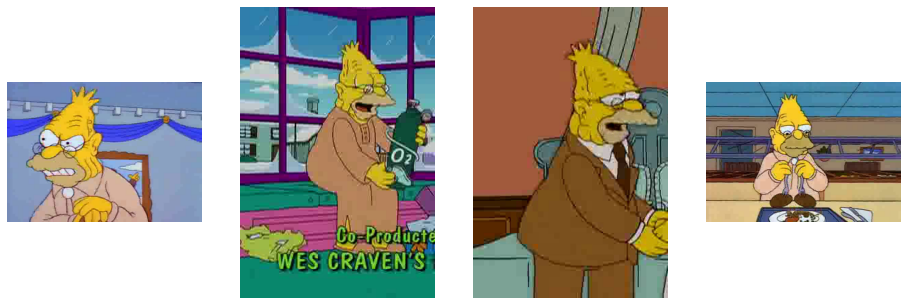

In [12]:
file_path = [train_val_files[13], train_val_files[4], train_val_files[777], train_val_files[666]]
fig = plt.figure(figsize=(16, 8))
rows = 1
columns = 4
for i in range (len(file_path)):
    fig.add_subplot(rows, columns, i+1)
    image = Image.open(file_path[i])
    plt.imshow(image)
    plt.axis('off')

Как мы видим: все фотографии разного размера, нужно это исправить

# Подготовка данных
<br>
Улучшим ситуацию с дисбалансом классов с помощью аугментации изображений, допустим в каждом классе у нас не менее 1500 изображений

In [13]:
df['to_add'] = df['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

Столбец one_iteration покажет нам, сколько новых изображений мы должны сделать из одного исходного изображения.

In [14]:
import math

df['one_iteration'] = df.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
df

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55
gil,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


# Аугментация

Посмотрим как работает аугментация: http://pytorch.org/vision/master/auto_examples/plot_transforms.html

In [15]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=224),
                                transforms.RandomCrop(174)
                                ]),
    'Rotation': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'Perspective': transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
}

In [16]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

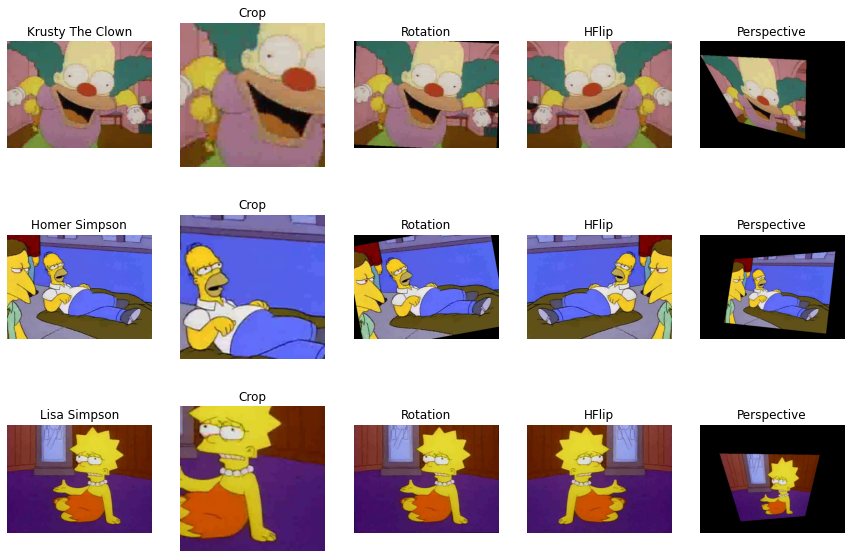

In [17]:
n_examples = 3 # отображение 3х изображений

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(15, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files))) # берем рандомный индекс фотографии
    img_orig = load_image(train_val_files[random_character]) # подгружаем его
    img_label = train_val_files[random_character].parent.name # подтягиваем лейбл фотографии

    img_label = " ".join(map(lambda x: x.capitalize(),img_label.split('_'))) # делаем наш лейбл читаемым
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()): # вывод результатов аугментации
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Применим аугментацию для изображений и сохраним результаты в папке train

In [18]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.RandomCrop(224)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)

Рассчитаем веса для классов. Менее популярный класс будет иметь меньший вес.

In [19]:
from collections import Counter

class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight
    
N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=256, sampler=train_sampler, num_workers=2)

100%|██████████| 20933/20933 [03:29<00:00, 99.68it/s] 


Посмотрим теперь на распределение классов

In [20]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 369/369 [08:22<00:00,  1.36s/it]

94332 Counter({32: 2342, 8: 2342, 40: 2317, 29: 2306, 2: 2299, 3: 2297, 41: 2296, 14: 2293, 18: 2284, 1: 2282, 33: 2279, 13: 2265, 36: 2263, 24: 2262, 28: 2260, 39: 2259, 6: 2256, 34: 2256, 0: 2253, 9: 2249, 21: 2246, 20: 2245, 27: 2241, 37: 2241, 25: 2240, 23: 2238, 12: 2233, 30: 2230, 31: 2226, 10: 2224, 19: 2222, 35: 2221, 26: 2220, 11: 2219, 4: 2217, 5: 2200, 17: 2199, 22: 2177, 7: 2172, 16: 2160, 15: 2157, 38: 2144})


Как мы видим, нам удолось улучшить ситуацию с несбалансированными данными

# Построение нейросети

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = func.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [23]:
n_classes = len(np.unique(train_val_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Sequential(
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Sequential(
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True),
    nn.Dropout(p=0.2),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6):

In [24]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=256)

epoch:   5%|▌         | 1/20 [09:17<2:56:36, 557.71s/it]


Epoch 001 train_loss: 1.6142 train_acc 0.5834


epoch:  10%|█         | 2/20 [18:26<2:45:44, 552.46s/it]


Epoch 002 train_loss: 0.5879 train_acc 0.8461


epoch:  15%|█▌        | 3/20 [27:33<2:35:47, 549.83s/it]


Epoch 003 train_loss: 0.3839 train_acc 0.8978


epoch:  20%|██        | 4/20 [36:35<2:25:47, 546.74s/it]


Epoch 004 train_loss: 0.2903 train_acc 0.9231


epoch:  25%|██▌       | 5/20 [45:39<2:16:28, 545.87s/it]


Epoch 005 train_loss: 0.2483 train_acc 0.9329


epoch:  30%|███       | 6/20 [54:41<2:07:04, 544.58s/it]


Epoch 006 train_loss: 0.2032 train_acc 0.9443


epoch:  35%|███▌      | 7/20 [1:03:42<1:57:41, 543.23s/it]


Epoch 007 train_loss: 0.1748 train_acc 0.9515


epoch:  40%|████      | 8/20 [1:12:41<1:48:25, 542.14s/it]


Epoch 008 train_loss: 0.1244 train_acc 0.9661


epoch:  45%|████▌     | 9/20 [1:21:37<1:39:01, 540.15s/it]


Epoch 009 train_loss: 0.1080 train_acc 0.9716


epoch:  50%|█████     | 10/20 [1:30:40<1:30:09, 540.97s/it]


Epoch 010 train_loss: 0.1027 train_acc 0.9725


epoch:  55%|█████▌    | 11/20 [1:39:41<1:21:09, 541.06s/it]


Epoch 011 train_loss: 0.0949 train_acc 0.9743


epoch:  60%|██████    | 12/20 [1:48:39<1:12:00, 540.10s/it]


Epoch 012 train_loss: 0.0917 train_acc 0.9756


epoch:  65%|██████▌   | 13/20 [1:57:37<1:02:55, 539.33s/it]


Epoch 013 train_loss: 0.0867 train_acc 0.9763


epoch:  70%|███████   | 14/20 [2:06:35<53:54, 539.07s/it]  


Epoch 014 train_loss: 0.0802 train_acc 0.9781


epoch:  75%|███████▌  | 15/20 [2:15:31<44:50, 538.05s/it]


Epoch 015 train_loss: 0.0804 train_acc 0.9789


epoch:  80%|████████  | 16/20 [2:24:32<35:56, 539.10s/it]


Epoch 016 train_loss: 0.0772 train_acc 0.9788


epoch:  85%|████████▌ | 17/20 [2:33:33<26:58, 539.56s/it]


Epoch 017 train_loss: 0.0738 train_acc 0.9797


epoch:  90%|█████████ | 18/20 [2:42:37<18:01, 541.00s/it]


Epoch 018 train_loss: 0.0767 train_acc 0.9792


epoch:  95%|█████████▌| 19/20 [2:51:46<09:03, 543.40s/it]


Epoch 019 train_loss: 0.0780 train_acc 0.9787


epoch: 100%|██████████| 20/20 [3:00:43<00:00, 542.18s/it]


Epoch 020 train_loss: 0.0736 train_acc 0.9808


In [27]:
loss, acc = zip(*history)

Посмотрим на график лосс-функции

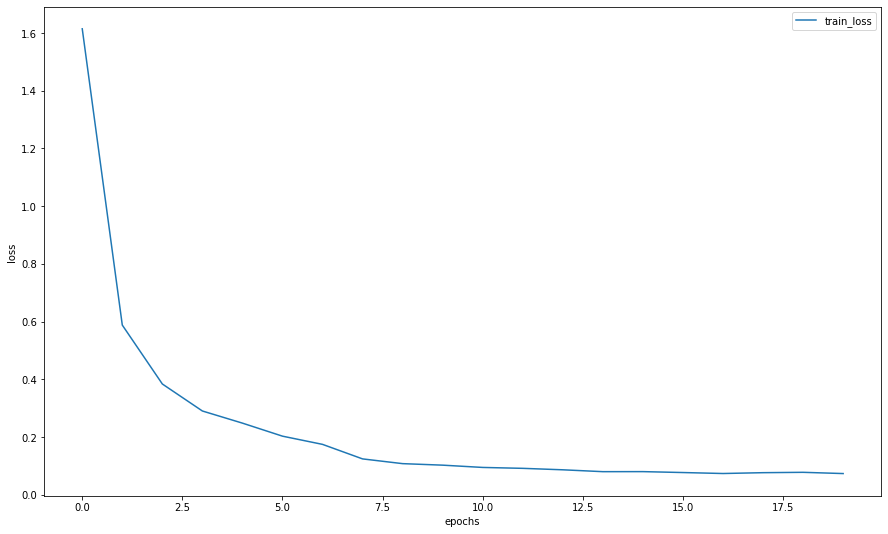

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [29]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [34]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = func.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [35]:
test_dataset = TestDataset(test_val_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

# BaseLine Score и сохранение результатов

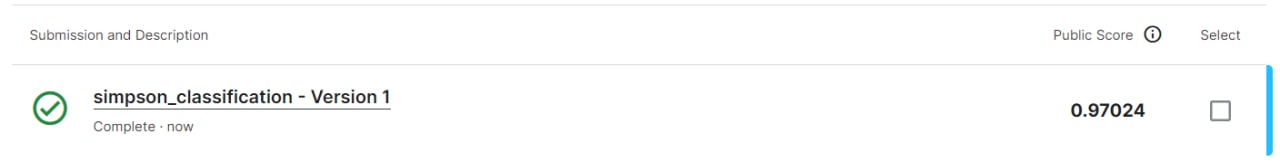

Скор улучшенной модели бейзлайна:

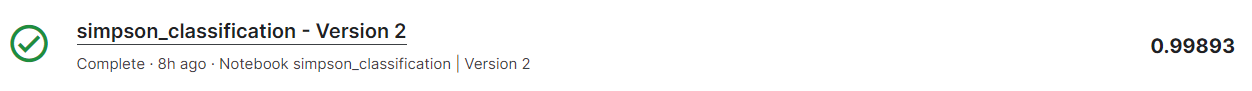

Мною также были опробованы Dropout-ы, но они давали менее точный скор: 0.99681

In [3]:
my_submit = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})

NameError: name 'test_filenames' is not defined

In [ ]:
my_submit.head()

In [ ]:
my_submit.to_csv("submission.csv", index=False)